In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quant_tools.data_preprocessing as dp

In [1]:
roulette_probs = {  "black" : 18/38,
                    "red" : 18/38,
                    "zero" : 1/38,
                    "double_zero" : 1/38
                }

In [4]:
consecutive_probabilities = pd.DataFrame(columns=['black', 'red', 'zero', 'double_zero'], index=range(1, 21))

for col in consecutive_probabilities.columns:
    for i in range(1, 21):
        consecutive_probabilities[col].loc[i] = roulette_probs[col]**i

consecutive_probabilities

,black,red,zero,double_zero
1,0.473684,0.473684,0.026316,0.026316
2,0.224377,0.224377,0.000693,0.000693
3,0.106284,0.106284,0.000018,0.000018
4,0.050345,0.050345,0.0,0.0
5,0.023848,0.023848,0.0,0.0
6,0.011296,0.011296,0.0,0.0
7,0.005351,0.005351,0.0,0.0
8,0.002535,0.002535,0.0,0.0
9,0.001201,0.001201,0.0,0.0
10,0.000569,0.000569,0.0,0.0


Run Monte Carlo Simulation

In [6]:
N_SIM = 5000
N_PLAYER = 1000

sim = np.random.choice(consecutive_probabilities.columns, size=(1000, 1000), p=consecutive_probabilities.iloc[0, :])
sim = pd.DataFrame(sim)

Simulate Each Game

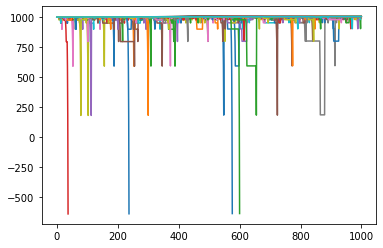

In [7]:
counter = 0
bet = 0.1
initial_bankroll = 1000
final_pnl = []

for col, tmp_sim in sim.items():
    
    color_time_series = []
    bankroll_time_series = [initial_bankroll]
    pnl_time_series = []
    bet_size_time_series = [bet]

    for i, color in tmp_sim.items():

        if len(color_time_series) > 0:

            if color == "black" and color_time_series[-1] >= 3:

                bankroll = bankroll_time_series[-1] + bet_size_time_series[-1]
                bankroll_time_series.append(bankroll)
                pnl_time_series.append(bet)
                bet_size_time_series.append(bet)

            elif color_time_series[-1] >= 3 and color != "black":

                bankroll = bankroll_time_series[-1] - bet_size_time_series[-1]
                bankroll_time_series.append(bankroll)
                pnl_time_series.append(-bet_size_time_series[-1])
                bet_size_time_series.append(bet_size_time_series[-1] * 2)
            else:
                bankroll_time_series.append(bankroll_time_series[-1])
        
        if color == "red":
            counter += 1
        else: 
            counter = 0

        # Stop loss
        if bankroll_time_series[-1] <= 0:
            break 

        color_time_series.append(counter)

    color_time_series = pd.Series(color_time_series)
    bankroll_time_series = pd.Series(bankroll_time_series)
    pnl_time_series = pd.Series(pnl_time_series)

    bankroll_time_series.plot()
    
    final_pnl.append(bankroll_time_series.iloc[-1])

plt.show()

In [8]:
final_pnl = pd.Series(final_pnl)
print(final_pnl.median())
final_pnl[final_pnl < 0].count() / final_pnl.count()

1004.9999999999994


0.004

<AxesSubplot:>

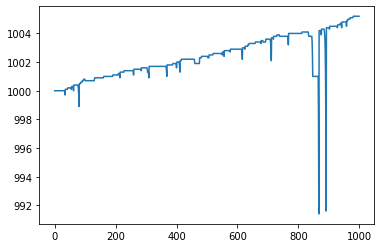

In [9]:
bankroll_time_series.plot()

In [46]:
bankroll_time_series.head(100).ewm(span=10, com=20, halflife=5)

Object `bankroll_time_series.head(100).ewm(span=10, com=20, halflife=5)` not found.


<AxesSubplot:>

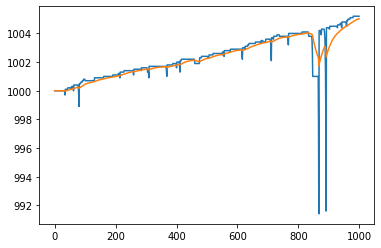

In [23]:
bankroll_time_series.head(1000).plot()
dp.ewma(bankroll_time_series.head(1000), span=50).plot()

<AxesSubplot:>

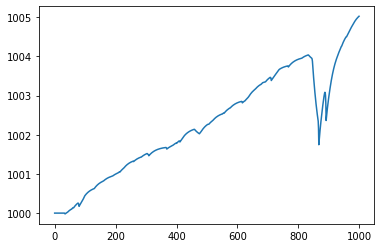

In [22]:
dp.ewma(bankroll_time_series.head(1000), span=50).plot()

<AxesSubplot:>

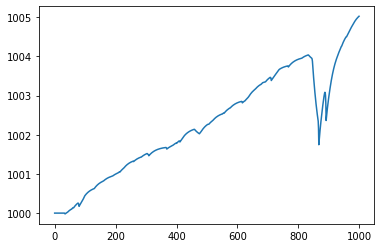

In [24]:
import quant_tools.time_series_analysis as tsa

tsa.ewma(bankroll_time_series.head(1000), span=50).plot()

In [46]:
# -------------------------------- Volatility Models --------------------------------
def ewma_vol(returns: pd.DataFrame, lookback: int = 60) -> pd.DataFrame:
    """
    Compute the covariance matrix of returns based on the given methodology.
    
    Args:
        returns (pd.DataFrame): historical returns.
        lookback (int, optional): exponentially-weighted daily returns with a "lookback_vol" day center-of-mass.
        
    Returns:
        pd.DataFrame: ewma volatility estimates.
    """
        
    # Calculate volatility estimates
    vols = returns.ewm(span=lookback).std().iloc[-1]
    
        
    return vols

def ewma_vol_2(returns: pd.DataFrame, lookback: int = 60) -> pd.DataFrame:
    """
    Compute the covariance matrix of returns based on the given methodology.
    
    Args:
        returns (pd.DataFrame): historical returns.
        lookback (int, optional): exponentially-weighted daily returns with a "lookback_vol" day center-of-mass.
        
    Returns:
        pd.DataFrame: ewma volatility estimates.
    """
        
    # Calculate squared returns
    squared_returns = np.square(returns)
    
    # Apply EWMA calculation to squared returns
    ewma_squared_returns = squared_returns.ewm(span=lookback).mean()

    # Sum the above product to get the EWMA variance
    ewma_variance =  np.sum(ewma_squared_returns)
    
    # Compute volatility as the square root of the EWMA values
    vols = np.sqrt(ewma_variance)
        
    return vols    

In [37]:
bankroll_time_series.ewm(span=10)

ExponentialMovingWindow [span=10,min_periods=1,adjust=True,ignore_na=False,axis=0]

In [38]:
ewma_vol(bankroll_time_series.head(1000))

0.6909570396439312

In [47]:
ewma_vol_2(bankroll_time_series.head(1000))

31693.924808783504